In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
#import seaborn as sns
import itertools as itrt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from IPython.display import clear_output
from itertools import repeat
from functools import partial
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import gaussian_kde
import scipy.stats as sct
from astropy.coordinates import SkyCoord as scr
from astropy import units as u
from time import sleep
from numba import jit, njit, prange
from tqdm import tqdm

#### ALL SIGNAL AND BGND PDFS HAVE BEEN WRITTEN TO .TXT FILES

In [2]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
t_eff_path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/uptime"
irf_path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/irfs"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    #print(len(lines) - 1)
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column, dtype=float)#.convert_dtypes(infer_objects=True,convert_integer=True,convert_floating=True)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]
icdata['MJD[days]'] = [float(i) for i in icdata['MJD[days]']]

print("read icdata")
f.close()



#Importing UPtime data
file = filenames[0]
f = open(os.path.join(t_eff_path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
uptdata = []
for file in filenames:
    content = []
    f = open(os.path.join(t_eff_path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
    temp = pd.DataFrame(content, columns=column)
    temp['MJD_start[days]'] = [float(i) for i in temp['MJD_start[days]']]
    temp['MJD_stop[days]'] = [float(i) for i in temp['MJD_stop[days]']]
    uptdata.append(temp)
    temp = []
    content = []
    print(file + " read")
f.close()


#Importing Aeff data
filenames = ["IC40_effectiveArea.csv", "IC59_effectiveArea.csv","IC79_effectiveArea.csv", "IC86_I_effectiveArea.csv", "IC86_II_effectiveArea.csv"]
file = filenames[0]
f = open(os.path.join(irf_path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
eadata = []
for file in filenames:
    content = []
    f = open(os.path.join(irf_path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
    temp = pd.DataFrame(content, columns=column, dtype=float)
    #temp['MJD_start[days]'] = [float(i) for i in temp['MJD_start[days]']]
    #temp['MJD_stop[days]'] = [float(i) for i in temp['MJD_stop[days]']]
    eadata.append(temp)
    temp = []
    content = []
    print(file + " read")
f.close()

read icdata
IC40_exp.csv read
IC59_exp.csv read
IC79_exp.csv read
IC86_I_exp.csv read
IC86_II_exp.csv read
IC86_III_exp.csv read
IC86_IV_exp.csv read
IC86_V_exp.csv read
IC86_VI_exp.csv read
IC86_VII_exp.csv read
IC40_effectiveArea.csv read
IC59_effectiveArea.csv read
IC79_effectiveArea.csv read
IC86_I_effectiveArea.csv read
IC86_II_effectiveArea.csv read


In [3]:
icwidths = [int(i) for i in "0 36900 107011 93133 136244 112858 122541 127045 129311 123657 145750".split(' ')]
ictimes = [float(i) for i in icdata['MJD[days]']]
icparts = [np.sum(icwidths[:i]) for i in range(1,len(icwidths)+1)]  #paritions of icdata for each season (IC40, IC59, IC79, IC86_I, IC86_II)
#icparts.pop(-1)
#icparts
upt_icparts = icparts[:5]
upt_icparts.append(icparts[-1])
#len(upt_icparts) - 1 == len(eadata)

log_e = np.round(np.arange(2, 10.2, 0.2), 2) #log10(E/GeV) values range as in all 'effectiveArea' files

#dec_nu = mid point of Dec_nu_min and Dec_nu_max as in all 'effectiveArea' files
dec_nu = list(set(eadata[0]['Dec_nu_min[deg]'].values).union(set(eadata[0]['Dec_nu_max[deg]'].values)))

dec_nu.sort()
dec_nu = np.array(dec_nu)

e_nu = ((10**(log_e[:-1])+ 10**(log_e[1:]))/2)*1e9
#de_nu = 1e9**0.2
de_nu = 1e9*(10**log_e[1:] - 10**log_e[:-1])
#Test case for e_ind
nu_e = 5
e_ind = 0
for i in range(len(log_e) - 1):
    if nu_e >= log_e[i] and nu_e < log_e[i+1]:
        e_ind = i
print([e_ind, i])

[15, 39]


Importing ATNF Pulsar data

In [4]:
#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/allpsr1.68.txt", 'r')
lines = f.readlines()
content=[]
column=lines.pop(0).replace('x', '').replace('#', '').split()
for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
f.close()
mspdata = pd.DataFrame(content).drop(0, axis=1)#.dropna()#.drop_duplicates()#.drop(range(0,6)).dropna()

line = []
lines = []
mspdata.columns = column
column = []
content=[]
#mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
#mspdata = mspdata.reset_index()
#mspdata = mspdata.drop("index", axis=1)
mspdata

,NAME,RAJD,DECJD
0,J0002+6216,0.74238,62.26928
1,J0006+1834,1.52,18.5831
2,J0007+7303,1.7571,73.0521
3,J0011+08,2.9,8.17
4,B0011+47,3.57396,47.77594
...,...,...,...
3336,J2351+8533,357.764,85.55573
3337,J2352+65,358,65
3338,J2354-22,358.60833,-22.86472
3339,B2351+61,358.5199292,61.9296792


#### Vectorizing important & frequently used values

#### msra/dec store the ra/dec values of the pulsars

#### icra/dec store the ra/dec values of the neutrino events

#### icang stores the angular uncertainity

#### iceng stores the log(energy/GeV) of the neutrino events

In [5]:
msra = np.array([float(i) for i in mspdata['RAJD'].values])
msdec = np.array([float(i) for i in mspdata['DECJD'].values])
icra = np.array([float(i) for i in icdata['RA[deg]']])
icdec = np.array([float(i) for i in icdata['Dec[deg]']])
icang = np.array([float(i) for i in icdata['AngErr[deg]']])
iceng = np.array([float(i) for i in icdata['log10(E/GeV)']])
global p, lg, lnu
p = len(msra)
lg = len(icra) // p + 1
lnu = len(icra)
[min(icdec), max(icdec)]

[-89.957, 89.977]

In [6]:
upstop_ttt = np.asfarray([uptdata[i]['MJD_stop[days]'].values[-1] for i in range(len(uptdata))])
upstart_ttt = np.asfarray([uptdata[i]['MJD_start[days]'].values[0] for i in range(len(uptdata))])
earea = np.array([eadata[i]['A_Eff[cm^2]'].values for i in range(len(eadata))])# * 1e-4
vec_uptparts = np.asarray(upt_icparts, dtype=np.int64)
upt_icparts = np.asarray(upt_icparts)

In [7]:
upstop_ttt

array([54971.15026394, 55347.28439144, 55694.41019675, 56062.41831018,
       56414.41614583, 56783.57893518, 57160.04101851, 57528.85952546,
       57891.16406249, 58309.08234953])

In [8]:
uptdata[1]

,MJD_start[days],MJD_stop[days]
0,54971.154550,54971.239504
1,54971.242900,54971.256814
2,54971.260430,54971.593833
3,54971.594892,54971.928306
4,54971.929335,54972.139341
...,...,...
1233,55345.622201,55345.955574
1234,55345.956852,55346.290229
1235,55346.291510,55346.624887
1236,55346.626242,55346.959629


In [9]:
@jit(nopython=True, fastmath=True)
def Pr(x, Ns, S, B):

    '''
    Parameters
    ----------
    x : int
        Assumed no.of associated events

    Ns : int
        No.of neutrinos used for analysis

    S : float
        Signal PDF
    B : float
        Background PDF
    
    Returns
    -------
    float 
        Returns the probability of the selected set of neutrinos being associated\n
        with a given pulsar with {Ns} neutrinos, {S} signal and {B} background PDF and {x} assumed associated events
    '''

    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))


@jit(nopython=True, fastmath=True)
def wall_nu(nu):
    
        '''
        Parameters
        ----------
        nu : int
            Index of the neutrino from IceCube sample
        
    
        Returns
        -------
        int
            Returns the index of the wall in which the {nu}th neutrino lies
        '''
        wall = 0
        for i in range(len(vec_uptparts)-1):
            if vec_uptparts[i] <= nu and vec_uptparts[i+1] > nu:
                wall = i
                break        
        return wall


@jit(nopython=True, fastmath=True)
def TS_st(x, S, B, Ns):

    ''' 
    Returns
    ----------
        Returns the Test Stastic value at
        $n_s$ = {x} for its parameters S, B, Ns
    '''
    if x >=0:
        return np.sum(np.asfarray(2*np.log(Pr(x,  Ns, S, B)/B)))
    else:
        return -1

def ns_for_TSmax_st(S, B, Ns):
    '''
    Returns the value of $n_s$ for which
    the TS is maximum for {i}^th grb
    '''

    #returns the TSmax for i^th GRB
    nll = lambda x: -TS_st(x, S, B, Ns)
    soln = minimize(nll, 3 , bounds = [(0, None)], tol=1e-12)
    ns = np.round(soln.x, 6)[0]
    #print(soln.success)
    return ns

Ns = lnu#np.count_nonzero(nuind+1)
@njit(parallel=True, fastmath=True)
def Ts_arr(x, S_all, B_all, Ns):
    '''
    Parameters
    ----------
    x : float
        The value of x for which the TS is to be calculated

    S_all : array
        The array of signal PDFs for all the neutrinos

    B_all : array
        The array of background PDFs for all the neutrinos
    
    Ns : int
        The number of neutrinos

    Returns
    -------
    float
        The TS value for the entire stack of neutrinos for the given value of x
    
    '''


    #Ts_arr = lambda x:
    sum = 0.0
    for i in range(lnu):
        sum += TS_st(x, S_all[i], B_all[i], Ns)
    return sum

@njit(fastmath=True)
def Ts_arr2(x, S_all, B_all, Ns):
    '''
    Parameters
    ----------
    x : float
        The value of x for which the TS is to be calculated

    S_all : array
        The array of signal PDFs for all the neutrinos

    B_all : array
        The array of background PDFs for all the neutrinos
    
    Ns : int
        The number of neutrinos

    Returns
    -------
    float
        The TS value for the entire stack of neutrinos for the given value of x
    
    '''


    #Ts_arr = lambda x:
    sum = 0.0
    for i in range(lnu):
        sum += TS_st(x, S_all[i], B_all[i], Ns)
    return sum



In [10]:
sigfilepath = "/media/darkwake/VIB2/Project-IceCube/task4/outputs/"
bgfilepath = "/media/darkwake/VIB2/Project-IceCube/task4/outputs/all_Bi.txt"

gamma = [-1, -2, -2.5, -3]
all_sig = []
for i in range(4):
    all_sig.append(np.loadtxt(sigfilepath + "sigbag_nu" + str(gamma[i]) + ".txt"))

all_sig = np.asfarray(all_sig)
all_bg = np.loadtxt(bgfilepath)

In [11]:
all_sig.shape

(4, 1134450)

![SNOWFALL](stnu.png)

$\hat{n}_s = 2\pi \sum_k t_k \sum_j \dfrac{sin(\delta_{j+1}) - sin(\delta_j)}{\delta_{j+1} - \delta_j}\sum_{\nu} A_{eff}^k (E_\nu, \delta_j) \dfrac{dF}{dE_\nu}$

$\dfrac{dF}{dE} = \phi_0 \{\dfrac{E_{\nu}}{100 TeV}\}^\Gamma$

In [12]:
def dfde(e_nu, gamma, phi0 = 1):
    '''
    Parameters
    ----------
    e_nu : float
        The neutrino energy in eV
    
    gamma : float
        The spectral index of the neutrino flux
    
    phi0 : float (optional)
        The normalization constant of the neutrino flux
    
    Returns
    -------
    float
        The differential flux of neutrinos
    '''

    return phi0 * (e_nu/1e14)**(gamma)

dec_nu2 = (dec_nu[1:] + dec_nu[:-1])/2
dec_nu2

ks = [0, 1, 2, 3, 4, 4, 4, 4, 4, 4]
a = 0
for k in range(len(upstop_ttt)):
    t_k = upstop_ttt[k] - upstart_ttt[k]
    for j in range(len(earea[ks[k]])):
        a+=1

a    

In [13]:
dfde(1e13, 2, 1e-18)

1.0000000000000002e-20

In [14]:
t_upt = (upstop_ttt - upstart_ttt)*86400

e_nu = 10**log_e * 1e9

In [15]:
season = 0
enu = 1e17#1 Gev to 1e7 Gev
gamma = -2.5
phi0 = 1e-18
dfde(enu, gamma, phi0)

i = 0
for i in range(0, len(e_nu)):
    if e_nu[i] <= enu and e_nu[i+1] > enu and log_e[i]:# < np.log10(enu) - 9 and log_e[i+1] > np.log10(enu) - 9:
        break
print(i)
print([e_nu[i], e_nu[i+1]])
print(np.log10(enu) - 9)
temp_ea = np.array(earea[season][i::40])
print(temp_ea)
sin_delta = np.sin(np.deg2rad(dec_nu))
d_sin_delta = sin_delta[1:] - sin_delta[:-1]

t_upt[season] * (enu**2) * np.dot(temp_ea, d_sin_delta) * dfde(enu, gamma, phi0)



30
[1e+17, 1.584893192461111e+17]
8.0
[1.47834089e+06 1.66969959e+06 1.68308636e+06 1.73920313e+06
 2.11377692e+06 2.37735775e+06 2.75482282e+06 3.13273613e+06
 3.28832154e+06 3.77148812e+06 4.22162654e+06 4.90063557e+06
 5.36826492e+06 6.32324822e+06 7.37146353e+06 8.35369253e+06
 9.70870910e+06 1.15341425e+07 1.38143314e+07 1.69772778e+07
 2.08644749e+07 2.73132202e+07 3.69827915e+07 5.34018114e+07
 5.36813006e+07 4.83702516e+07 3.92758826e+07 2.15740099e+07
 1.05648515e+07 4.80675258e+06 2.92097990e+06 1.48963944e+06
 5.27148870e+05 7.72211740e+05 7.88513100e+04 1.20963600e+04
 2.41426300e+04 3.02260900e+04 3.37223600e+04 6.38268000e+03
 0.00000000e+00 2.53291000e+03 0.00000000e+00 4.30203000e+03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


1.9448702597303276e+23

In [16]:
10 ** log_e[30] * 1e9

1e+17

In [17]:
len(uptdata)

10

In [34]:
log_e+9

array([11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. ,
       13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2,
       15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4,
       17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. ])

In [37]:
earea[1][1::40]

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.32,  8.89, 18.37, 17.88,
       20.17, 17.49, 21.81, 17.97, 22.15, 21.77, 25.96, 25.63, 24.46,
       28.15, 23.09, 23.91, 33.85, 25.15, 29.06, 36.68, 25.23, 27.47,
       43.66, 32.39, 39.53, 24.89, 11.93])

In [38]:
def ns_singleseason_HAT(enu, gamma, phi0, season):
    t_upt = (upstop_ttt[season] - upstart_ttt[season])*86400
    if enu <= 1e11 or enu > 1e19:
        return 40*[0]
    
    else:
        for i in range(0, len(e_nu)):
            if e_nu[i] <= enu and e_nu[i+1] > enu:
                break
                
        ea_season = [0, 1, 2, 3, 4, 4, 4, 4, 4, 4]
        temp_ea = np.array(earea[ea_season[season]][i::40])
        sin_delta = np.sin(np.deg2rad(dec_nu))

        return t_upt * (enu**2) * np.dot(temp_ea, (sin_delta[1:] - sin_delta[:-1])) * dfde(enu, gamma, phi0)

In [39]:
nll = lambda x: -ns_singleseason_HAT(1e16, -2, x, 1)
soln = minimize(nll, 1e-14, bounds = [(0, None)], tol=1e-12)
print(soln.x)

[3.83256184e+89]


In [44]:
10** (19) 

10000000000000000000

In [45]:

for i in range(10):
    soln = []

    for enu in tqdm(np.linspace(2e11, 1e18, 51)):
        nll = lambda x: -ns_singleseason_HAT(enu, -2, x, i)
        soln.append(minimize(nll, 1e-37, bounds = [(0, None)], tol=1e-12).x)
    print(np.median(soln))

100%|██████████| 51/51 [00:00<00:00, 67.43it/s]


3.7337396417212656e+88


100%|██████████| 51/51 [00:00<00:00, 72.48it/s]


1.6210807326091417e+72


100%|██████████| 51/51 [00:00<00:00, 83.39it/s]


1.8186655450272638e+71


100%|██████████| 51/51 [00:00<00:00, 136.27it/s]


1e-37


100%|██████████| 51/51 [00:00<00:00, 104.63it/s]


89478484.99999999


100%|██████████| 51/51 [00:00<00:00, 104.14it/s]


89478484.99999999


100%|██████████| 51/51 [00:00<00:00, 117.42it/s]


1e-37


100%|██████████| 51/51 [00:00<00:00, 111.66it/s]


1e-37


100%|██████████| 51/51 [00:00<00:00, 98.31it/s] 


89478485.00000001


100%|██████████| 51/51 [00:00<00:00, 91.55it/s]

89478484.99999999


In [ ]:
np.mean(soln)

4.270731049045408e+128

In [ ]:
min

In [ ]:
max(soln)

array([4.27073105e+131])

In [23]:
all_soln = []
for i in range(10):
    soln = []
    for enu in np.linspace(1e12, 1e16, 10**2):
        nll = lambda x: -ns_singleseason_HAT(enu, -2, x, i)
        soln.append(minimize(nll, 1e34, bounds = [(0, None)], tol=1e-12).x)
    all_soln.append(np.mean(soln))
    

In [24]:
all_soln

[9.999999999999997e+33,
 9.999999999999997e+33,
 9.999999999999997e+33,
 9.999999999999997e+33,
 9.999999999999997e+33,
 9.999999999999997e+33,
 9.999999999999997e+33,
 9.999999999999997e+33,
 9.999999999999997e+33,
 9.999999999999997e+33]

In [ ]:
n_s_HAT(1e17, -2.5, 1e17)

3.3186969899484726e+59

In [ ]:
def n_s_HAT(enu, gamma, phi0):
    '''
    Parameters
    ----------
    enu : float
        The neutrino energy in eV
    
    gamma : float
        The spectral index of the neutrino flux
    
    Returns
    -------
    float
        The number of neutrinos to be used for analysis
    '''
    n_s = 0
    for season in range(len(uptdata)):
        t_upt = (upstop_ttt[season] - upstart_ttt[season])*86400
        for i in range(0, len(e_nu)):
            if e_nu[i] <= enu and e_nu[i+1] > enu:
                break
        
        ea_season = [0, 1, 2, 3, 4, 4, 4, 4, 4, 4]
        temp_ea = np.array(earea[ea_season[season]][i::40])
        sin_delta = np.sin(np.deg2rad(dec_nu))
        n_s += t_upt * (enu**2) * np.dot(temp_ea, (sin_delta[1:] - sin_delta[:-1])) * dfde(enu, gamma, phi0)
    
    # print(n_s)    
    return n_s    

In [ ]:
def ns_maxhat(enu, gamma):
    nll = lambda x: n_s_HAT(enu, gamma, x)
    soln = minimize(nll, 1e18, bounds = [(0, None)], tol=1e-12)
    return soln.x

In [ ]:
n_s_HAT(1e17, -2.5, ns_maxhat(1e17, -2.5))

array([3.31869699e+60])

In [ ]:
Ts_arr2(n_s_HAT(1e17, -2.5, ns_maxhat(1e17, -2.5)), all_sig[2], all_bg, lnu)

nan

In [ ]:
soln = minimize(nll, 1e-4, method='Nelder-Mead', tol=1e-12)

In [ ]:
nll(soln.x)

array([-2.42884391e+66])

In [ ]:
Ts_arr2(-nll(soln.x), all_sig[2], all_bg, lnu)

nan

In [ ]:
all_bg.shape

(1134450,)

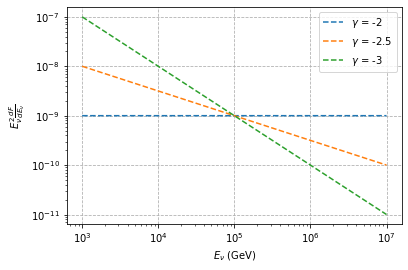

In [ ]:
plt.figure()
test_e = np.linspace(1e12, 1e16, 100000)
for gamma in [-2, -2.5, -3]:
    plt.plot(test_e/1e9, np.multiply(test_e ** 2, dfde(test_e, gamma, 1e-32)) * 1e4/1e9, label = r'$\gamma$ = ' + str(gamma), ls = '--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$E_{\nu}^2 \frac{dF}{dE_{\nu}}$')
plt.grid(True, which="major", ls="--")
plt.legend()
plt.show()

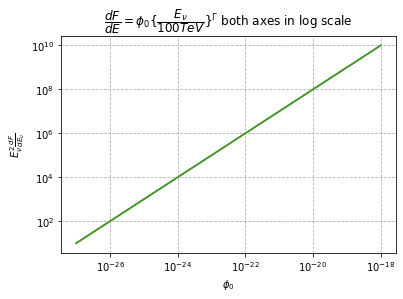

In [ ]:
phi0s = np.linspace(1e-27, 1e-18, 1000000)
for gamma in [-2, -2.5, -3]:
    plt.plot(phi0s, 1e28 * dfde(1e14, gamma, phi0s))

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\phi_0$')
plt.ylabel(r'$E_{\nu}^2 \frac{dF}{dE_{\nu}}$')
plt.title(r'$\dfrac{dF}{dE} = \phi_0 \{\dfrac{E_{\nu}}{100 TeV}\}^\Gamma$ both axes in log scale')
plt.grid(True, which="major", ls="--")
# plt.plot(phi0s, dfde(1e14, gamma, phi0s))
plt.show()

In [25]:
iceng

array([3.31, 5.17, 3.92, ..., 2.88, 2.98, 3.28])

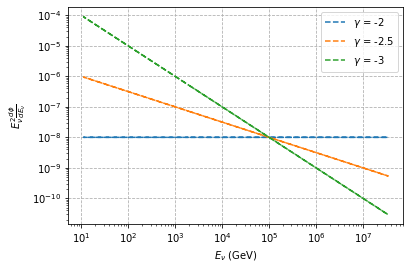

In [26]:
plt.figure()
test_e2 = 10**iceng * 1e9
for gamma in [-2, -2.5, -3]:
    plt.plot(test_e/1e9, np.multiply(test_e ** 2, dfde(test_e, gamma, 1e-27))/1e9, label = r'$\gamma$ = ' + str(gamma), ls = '-*')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$E_{\nu}^2 \frac{d\phi}{dE_{\nu}}$')
plt.grid(True, which="major", ls="--")
plt.legend()
plt.show()